In [1]:
# 2017-10-03 baseline (only)                         --> LB=0.78
# 2017-10-03 baseline with lemmarization (pymorphy2) --> LB=0.83991
# 2017-10-03 baseline + lemmarization (pymorphy2)
# 2017-10-04 baseline + lemmarization (pymorphy2) + base
# 2017-10-05 baseline + lemmarization (pymorphy2) + base + XGB(natural) --> LB=0.8688
# 2017-10-07 baseline + lemmarization (pymorphy2) + base - stopWords XGB(natural) -> 0.8755666207002808
#
#2017-10-13 + test.paragraph on sentences -> 0.9164478890738156
#
# 2017-10-30 -> 0.9331374717885157

In [2]:
from __future__ import division
import sys, os, datetime
import pandas as pd
from collections import Counter
import functools
#import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as skm
import sklearn.model_selection as skms
import pymorphy2

In [3]:
import gensim.models.word2vec

Using TensorFlow backend.


In [315]:
#dftrain, dftest = pd.read_csv("../Data/train_task1_latest.csv"), pd.read_csv("../Data/test_task1_latest.csv")
dftrain, dftest = pd.read_csv("../Work/train_task1_lemma.csv"), pd.read_csv("../Work/test_task1_lemma.csv")

In [316]:
dftrain.shape, dftest.shape, dftrain.columns.tolist()

((119398, 13),
 (74294, 12),
 ['paragraph_id',
  'question_id',
  'paragraph',
  'question',
  'target',
  'paragraphL',
  'questionL',
  'paragraphLS',
  'questionLS',
  'paragraphLX',
  'questionLX',
  'paragraphLSX',
  'questionLSX'])

In [317]:
#@functools.lru_cache(maxsize=2 ** 19)
def uniq_words_old_baseline(text):
    return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfs_old_baseline(data):
    counter_paragraph = Counter()
    uniq_paragraphs = data['paragraph'].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_words_old_baseline(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [318]:
#@functools.lru_cache(maxsize=2 ** 19)
def uniq_words(text):
    ttext = [mm2.parse(xx)[0].normal_form for xx in re.findall("\w+", text.decode('utf-8'),re.UNICODE) 
             if mm2.parse(xx)[0].tag.POS not in {'PREP','CONJ','PRCL','INTJ'}]
    return  set(ttext)
    #return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfs(data):
    counter_paragraph = Counter()
    uniq_paragraphs = data['paragraph'].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_words(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [319]:
#@functools.lru_cache(maxsize=2 ** 19)
# add truncate 3 word
def uniq_wordsX(text, minLen=3):
    ttext = [xx for xx in re.findall("\w+", text.decode('utf-8'),re.UNICODE) if len(xx)>=minLen]
    return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfsX(data, column='paragraph'):
    counter_paragraph = Counter()
    uniq_paragraphs = data[column].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_wordsX(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [320]:
idfs  = calculate_idfsX(dftrain,'paragraphLSX')
idfs0 = calculate_idfsX(dftrain,'paragraph')

In [321]:
dftrain[:1]

,paragraph_id,question_id,paragraph,question,target,paragraphL,questionL,paragraphLS,questionLS,paragraphLX,questionLX,paragraphLSX,questionLSX
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0,"в отличие от рыба , земноводный ( амфибия ) и ...",с какой год русский царство перейти на летоисч...,"отличие рыба , земноводный ( амфибия ) пресмык...",год русский царство перейти летоисчисление рож...,"отличие рыба , земноводный ( амфибия ) пресмык...",какой год русский царство перейти летоисчислен...,"отличие рыба , земноводный ( амфибия ) пресмык...",год русский царство перейти летоисчисление рож...


In [322]:
#print(dftrain.paragraph[0])

In [323]:
#paragraph = uniq_words(str(dftrain.paragraph[0]));
#print len(paragraph)
#for xx in paragraph : print xx

In [324]:
def newFields (paragraph, question) :
    return(len(paragraph), \
           len(question), \
           len(paragraph & question), \
           np.sum([idfs.get(word, 0.0) for word in question]), \
           np.sum([idfs.get(word, 0.0) for word in paragraph]), \
           np.sum([idfs.get(word, 0.0) for word in paragraph & question]), \
           float(len(paragraph & question))/len(question), \
           np.sum([idfs.get(word, 0.0) for word in paragraph & question])/(np.sum([idfs.get(word, 0.0) for word in question]))
          )

In [325]:
sentences  = dftrain['paragraphL'].tolist()+dftrain.questionL.tolist()
sentences += dftest ['paragraphL'].tolist()+dftest.questionL.tolist()
sentences = [[ss.decode('utf-8') for ss in s.split(' ')] for s in sentences]
print len(sentences) #, sentences[0]

387384


In [326]:
print datetime.datetime.now()
model = gensim.models.word2vec.Word2Vec(sentences, size=100, window=5, workers=4, min_count=1)
wv    = model.wv
print datetime.datetime.now()

2017-10-30 04:26:40.488286
2017-10-30 04:28:05.243394


In [327]:
if 0 : model.save("../Work/model_word2vec1"); wv=model.wv
if 1 : model = gensim.models.Word2Vec.load("../Work/model_word2vec1"); wv=model.wv

In [328]:
for name, df in [('train', dftrain), ('test', dftest)]:
    for index, row in df.iterrows() : #tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        
        if index%10000==0 : print datetime.datetime.now(), name, index
        
        question  = uniq_wordsX(row.questionLSX)
        paragraph = uniq_wordsX(row.paragraphLSX)
        PQ        = newFields (paragraph, question) 
        ##print index,PQ
        df.loc[index, 'len_paragraph']    = PQ[0]
        df.loc[index, 'len_question']     = PQ[1]
        df.loc[index, 'len_intersection'] = PQ[2]
        df.loc[index, 'idf_question']     = PQ[3]
        df.loc[index, 'idf_paragraph']    = PQ[4]
        df.loc[index, 'idf_intersection'] = PQ[5]
        
        df.loc[index, 'len_intNorm']      = PQ[6]
        df.loc[index, 'idf_intNorm']      = PQ[7]
        
        pp                    = [unicode(ppx,'utf-8') for ppx in row.paragraphLSX.split()]
        qq                    = [unicode(qqx,'utf-8') for qqx in row.questionLSX.split()]
        try    : w2v = wv.n_similarity(pp,qq)
        except : w2v = -2.0
            
        #for ppx in pp : print ppx, wv[ppx].shape
            
        df.loc[index, 'w2v_pqf'] = w2v
        
        df.loc[index, 'w2v_wmd'] = model2.wmdistance(pp,qq)

            
        #print w2v,pp,qq

        
        question  = uniq_wordsX(row.question)
        paragraph = uniq_wordsX(row.paragraph)
        PQ        = newFields (paragraph, question) 
        df.loc[index, 'len_paragraph0']    = PQ[0]
        df.loc[index, 'len_question0']     = PQ[1]
        df.loc[index, 'len_intersection0'] = PQ[2]
        df.loc[index, 'idf_question0']     = PQ[3]
        df.loc[index, 'idf_paragraph0']    = PQ[4]
        df.loc[index, 'idf_intersection0'] = PQ[5]
        
        df.loc[index, 'len_intNorm0']      = PQ[6]
        df.loc[index, 'idf_intNorm0']      = PQ[7]


2017-10-30 04:29:04.132219 train 0


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


2017-10-30 04:33:00.216084 train 10000
2017-10-30 04:36:52.028441 train 20000
2017-10-30 04:40:47.161004 train 30000
2017-10-30 04:44:46.135881 train 40000
2017-10-30 04:48:44.532433 train 50000
2017-10-30 04:52:36.304718 train 60000
2017-10-30 04:56:27.129838 train 70000
2017-10-30 05:00:19.049104 train 80000
2017-10-30 05:04:11.689934 train 90000
2017-10-30 05:08:00.921744 train 100000
2017-10-30 05:11:56.739159 train 110000
2017-10-30 05:15:34.730606 test 0
2017-10-30 05:19:44.110302 test 10000
2017-10-30 05:23:50.483046 test 20000
2017-10-30 05:27:59.802567 test 30000
2017-10-30 05:32:08.658610 test 40000
2017-10-30 05:36:15.891525 test 50000
2017-10-30 05:40:22.388936 test 60000
2017-10-30 05:44:31.574641 test 70000


In [329]:
dftrain.columns, dftest.columns

(Index([u'paragraph_id', u'question_id', u'paragraph', u'question', u'target',
        u'paragraphL', u'questionL', u'paragraphLS', u'questionLS',
        u'paragraphLX', u'questionLX', u'paragraphLSX', u'questionLSX',
        u'len_paragraph', u'len_question', u'len_intersection', u'idf_question',
        u'idf_paragraph', u'idf_intersection', u'len_intNorm', u'idf_intNorm',
        u'w2v_pqf', u'w2v_wmd', u'len_paragraph0', u'len_question0',
        u'len_intersection0', u'idf_question0', u'idf_paragraph0',
        u'idf_intersection0', u'len_intNorm0', u'idf_intNorm0'],
       dtype='object'),
 Index([u'paragraph_id', u'question_id', u'paragraph', u'question',
        u'paragraphL', u'questionL', u'paragraphLS', u'questionLS',
        u'paragraphLX', u'questionLX', u'paragraphLSX', u'questionLSX',
        u'len_paragraph', u'len_question', u'len_intersection', u'idf_question',
        u'idf_paragraph', u'idf_intersection', u'len_intNorm', u'idf_intNorm',
        u'w2v_pqf', u'w2v_wm

In [330]:
if 1 : 
    dftrain.to_csv("../Work/train_task1_compute.csv",index=False)
    dftest.to_csv ("../Work/test_task1_compute.csv",index=False)
if 0 : 
    dftrain, dftest = pd.read_csv("../Work/train_task1_compute.csv"), pd.read_csv("../Work/test_task1_compute.csv")

In [331]:
dftrain.loc[(np.isinf(dftrain.w2v_wmd)),'w2v_wmd']=-2
dftrain[(np.isinf(dftrain.w2v_wmd))].head()
dftrain.target.unique(), dftrain.shape, dftrain.target.mean(), dftrain[dftrain.target==1].shape, dftest.shape

(array([ 0.,  1.]),
 (119398, 31),
 0.28507177674667916,
 (34037, 31),
 (74294, 30))

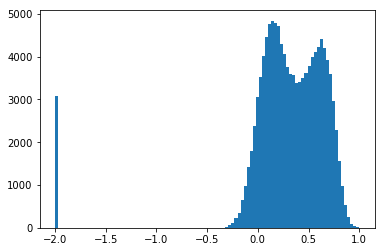

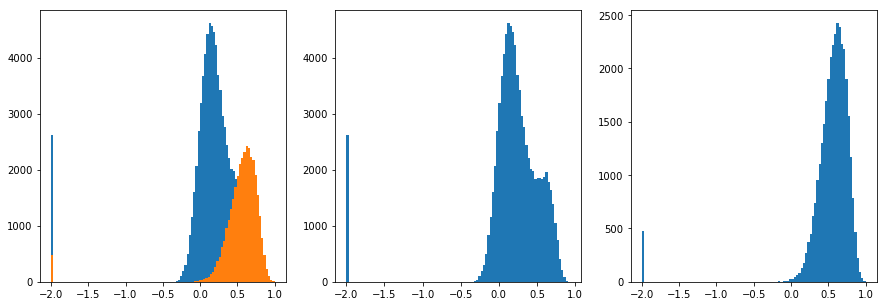

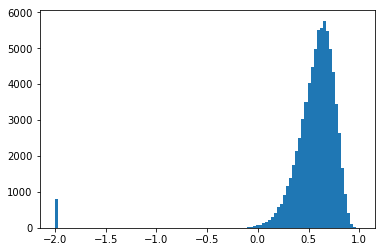

(-2.0, 0.99943272080415768, 0.99931279997425737, 3087, 803)

In [332]:
plt.hist(dftrain.w2v_pqf,bins=100); plt.show()
plt.figure(figsize=(15,5))
plt.subplot(131);
plt.hist(dftrain.w2v_pqf[dftrain.target==0],bins=100);
plt.hist(dftrain.w2v_pqf[dftrain.target==1],bins=100);
plt.subplot(132);
plt.hist(dftrain.w2v_pqf[dftrain.target==0],bins=100);
plt.subplot(133);
plt.hist(dftrain.w2v_pqf[dftrain.target==1],bins=100); 
plt.show()
plt.hist(dftest.w2v_pqf,bins=100); plt.show()
dftrain.w2v_pqf.min(),dftrain.w2v_pqf.max(),dftest.w2v_pqf.max(), len(dftrain[dftrain.w2v_pqf==-2]), len(dftest[dftest.w2v_pqf==-2])

In [199]:
dftrain.shape,dftest.shape

((119398, 30), (74294, 29))

In [200]:
# Build word2vec model 2

In [201]:
sentences  = dftrain['paragraphL'].tolist()
sentences += dftest ['paragraphL'].tolist()

ps = []
for ps1 in sentences : ps.extend(ps1.split('.'))
sentences = ps; del ps, ps1

sentences += dftrain.questionL.tolist()
sentences += dftest.questionL.tolist()
sentences = [[ss.decode('utf-8') for ss in s.split(' ')] for s in sentences]
print len(sentences) #, sentences[0]

1610230


In [202]:
print datetime.datetime.now()
model2 = gensim.models.word2vec.Word2Vec(sentences, size=100, window=5, workers=4, min_count=1)
wv    = model2.wv
print datetime.datetime.now()

2017-10-30 00:50:35.199235
2017-10-30 00:52:12.528671


In [333]:
if 0: model2.save("../Work/model_word2vec2"); wv=model2.wv
if 1: model2 = gensim.models.Word2Vec.load("../Work/model_word2vec2"); wv=model2.wv

In [334]:
#dftrain['w2v_wmd'] = -2.0
#dftest ['w2v_wmd'] = -2.0

#for name, df in [('train', dftrain), ('test', dftest)]:
for name, df in [('test', dftest)]:
    df1 = []; 
    for index, row0 in df.iterrows() : #tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        
        if index%10000==0 : print datetime.datetime.now(), name, index
            
        pars  = row0.paragraphLSX.split('.')
        pars0 = row0.paragraph.split('.')
        if len(pars)<1 : continue;
        
        for par0,par1 in zip(pars0,pars) :
            if len(par1)<=1 : continue
            row1 = row0.copy(); 
            
            row1.paragraph    = par0
            row1.paragraphLSX = par1
            
            #print(row1.paragraph)
            #print(row1.question)
            
            question  = uniq_wordsX(row1.questionLSX)
            paragraph = uniq_wordsX(row1.paragraphLSX)
            PQ        = newFields (paragraph, question) 
            row1.len_paragraph    = PQ[0]
            row1.len_question     = PQ[1]
            row1.len_intersection = PQ[2]
            row1.idf_question     = PQ[3]
            row1.idf_paragraph    = PQ[4]
            row1.idf_intersection = PQ[5]

            row1.len_intNorm      = PQ[6]
            row1.idf_intNorm      = PQ[7]
            
            '''
            pp                    = row1.paragraphLSX.split()
            qq                    = row1.questionLSX.split()
            '''
            pp                    = [unicode(ppx,'utf-8') for ppx in row1.paragraphLSX.split()]
            qq                    = [unicode(qqx,'utf-8') for qqx in row1.questionLSX.split()]
            try    : row1.w2v_pqf = wv.n_similarity(pp,qq)
            except : row1.w2v_pqf = -2.0
            
            row1.w2v_wmd = model2.wmdistance(pp,qq)
            
            '''
            question  = uniq_wordsX(row1.question)
            paragraph = uniq_wordsX(row1.paragraph)
            PQ        = newFields (paragraph, question) 
            row1.len_paragraph0   = PQ[0]
            row1.len_question0    = PQ[1]
            row1.len_intersection0= PQ[2]
            row1.idf_question0    = PQ[3]
            row1.idf_paragraph0   = PQ[4]
            row1.idf_intersection0= PQ[5]

            row1.len_intNorm0     = PQ[6]
            '''
            
            df1.append(row1)
        
    df1 = pd.DataFrame.from_dict(df1)
    if name=='train' :    dftrain  = df1; #dftrain.append(df1)
    if name=='test'  :    dftest   = df1; #dftest.append(df1)

2017-10-30 05:46:47.370234 test 0
2017-10-30 05:49:53.237300 test 10000


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


2017-10-30 05:52:48.107333 test 20000
2017-10-30 05:55:42.715377 test 30000
2017-10-30 05:58:34.485012 test 40000
2017-10-30 06:01:24.881845 test 50000
2017-10-30 06:04:12.145411 test 60000
2017-10-30 06:07:06.102070 test 70000


In [286]:
if 0 : 
    dftrain.to_csv("../Work/train_task2_compute.csv",index=False)
    dftest.to_csv ("../Work/test_task2_compute.csv",index=False)
if 1 : 
    dftrain, dftest = pd.read_csv("../Work/train_task2_compute.csv"), pd.read_csv("../Work/test_task2_compute.csv")

In [335]:
#row0,row1, 
print dftest.shape, dftrain.shape, dftrain.columns

(491449, 30) (119398, 31) Index([u'paragraph_id', u'question_id', u'paragraph', u'question', u'target',
       u'paragraphL', u'questionL', u'paragraphLS', u'questionLS',
       u'paragraphLX', u'questionLX', u'paragraphLSX', u'questionLSX',
       u'len_paragraph', u'len_question', u'len_intersection', u'idf_question',
       u'idf_paragraph', u'idf_intersection', u'len_intNorm', u'idf_intNorm',
       u'w2v_pqf', u'w2v_wmd', u'len_paragraph0', u'len_question0',
       u'len_intersection0', u'idf_question0', u'idf_paragraph0',
       u'idf_intersection0', u'len_intNorm0', u'idf_intNorm0'],
      dtype='object')


In [288]:
dff    = dftrain.copy()
print  dftrain.shape

# max only target==1
##dfgroup=dff[dff.target==1][['paragraph_id','question_id','w2v_pqf']].groupby(['paragraph_id','question_id'])
dfgroup=dff[dff.target==1][['paragraph_id','question_id','w2v_wmd']].groupby(['paragraph_id','question_id'])
dfw2v  =dfgroup.max()
##dff = dff.set_index(['paragraph_id','question_id','w2v_pqf'])
dff = dff.set_index(['paragraph_id','question_id','w2v_wmd'])
dff['ttarget']   = 0.0
dfw2v['ttarget'] = 1.0
##dfw2v = dfw2v.reset_index().set_index(['paragraph_id','question_id','w2v_pqf'])
dfw2v = dfw2v.reset_index().set_index(['paragraph_id','question_id','w2v_wmd'])
dff.ttarget = dfw2v.ttarget 
dff.loc[dff.target==0.0,'ttarget'] = 0.0 
dff = dff.dropna()
dff = dff.reset_index()

# max only target==0
dfgroup=dff[dff.target==0][['paragraph_id','question_id','w2v_pqf']].groupby(['paragraph_id','question_id'])
##dfgroup=dff[dff.target==0][['paragraph_id','question_id','w2v_wmd']].groupby(['paragraph_id','question_id'])
dfw2v  =dfgroup.max()
dff = dff.set_index(['paragraph_id','question_id','w2v_pqf'])
##dff = dff.set_index(['paragraph_id','question_id','w2v_wmd'])
dff['ttarget']   = -1.0
dfw2v['ttarget'] =  0.0
dfw2v = dfw2v.reset_index().set_index(['paragraph_id','question_id','w2v_pqf'])
##dfw2v = dfw2v.reset_index().set_index(['paragraph_id','question_id','w2v_wmd'])
dff.ttarget = dfw2v.ttarget 
dff.loc[dff.target==1.0,'ttarget'] = 1.0 
dff = dff.dropna()
dff = dff.reset_index()

dftrain = dff.copy()
dftrain.target = dftrain.ttarget
print  dftrain.shape
#print dftrain.head()
#plt.hist(dfw2v.w2v_pq1,bins=100); plt.show()

(728004, 31)
(116005, 32)


In [336]:
dftrain.loc[(np.isinf(dftrain.w2v_wmd)),'w2v_wmd']=-2
dftrain[(np.isinf(dftrain.w2v_wmd))].head()
dftrain.target.unique(), dftrain.shape, dftrain.target.mean(), dftrain[dftrain.target==1].shape, dftest.shape

(array([ 0.,  1.]),
 (119398, 31),
 0.28507177674667916,
 (34037, 31),
 (491449, 30))

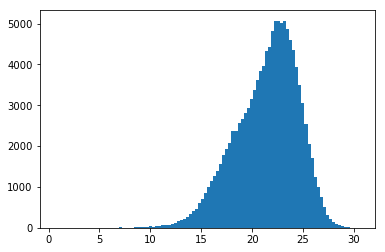

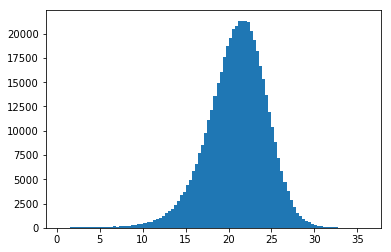

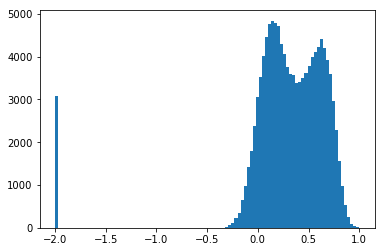

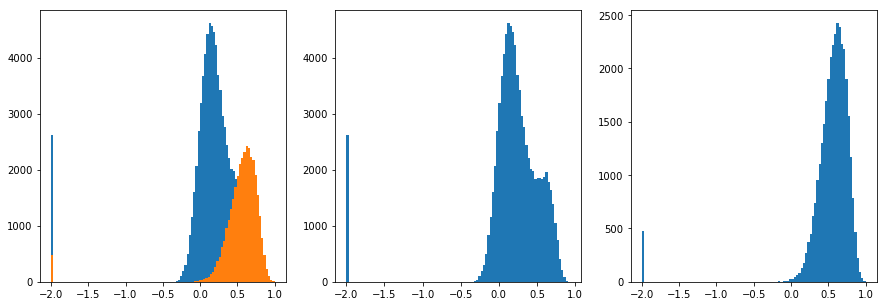

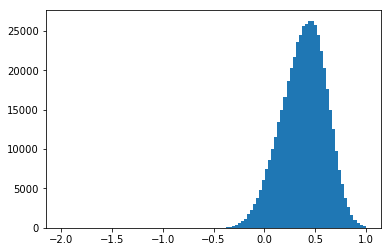

(-2.0, 0.99943272080415768, 0.99926666352040761, 3087, 6)

In [338]:
plt.hist(dftrain.w2v_wmd,bins=100); plt.show()
plt.hist(dftest.w2v_wmd,bins=100); plt.show()
plt.hist(dftrain.w2v_pqf,bins=100); plt.show()
plt.figure(figsize=(15,5))
plt.subplot(131);
plt.hist(dftrain.w2v_pqf[dftrain.target==0],bins=100);
plt.hist(dftrain.w2v_pqf[dftrain.target==1],bins=100);
plt.subplot(132);
plt.hist(dftrain.w2v_pqf[dftrain.target==0],bins=100);
plt.subplot(133);
plt.hist(dftrain.w2v_pqf[dftrain.target==1],bins=100); 
plt.show()
plt.hist(dftest.w2v_pqf,bins=100); plt.show()
dftrain.w2v_pqf.min(),dftrain.w2v_pqf.max(),dftest.w2v_pqf.max(), len(dftrain[dftrain.w2v_pqf==-2]), len(dftest[dftest.w2v_pqf==-2])

In [339]:
xx = dftrain[dftrain.w2v_pqf==-2][dftrain.target==1]
xx.shape
for ii,row1 in xx[:5].iterrows() :
        pp                    = row1.paragraphLSX.split()
        qq                    = row1.questionLSX.split()
        for ppx in pp :
            for qqx in qq :
                try : w2v_pqf = wv.similarity(unicode(ppx,'utf-8'),unicode(qqx,'utf-8'))
                except : print ppx,qqx

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [374]:
dftrain['len_queNorm']  = dftrain.len_question/dftrain.len_paragraph
dftrain['len_queNorm0'] = dftrain.len_question0/dftrain.len_paragraph0
dftest['len_queNorm']   = dftest.len_question/dftest.len_paragraph
dftest['len_queNorm0']  = dftest.len_question0/dftest.len_paragraph0

dftrain['idf_queNorm']  = dftrain.idf_question/dftrain.idf_paragraph
dftrain['idf_queNorm0'] = dftrain.idf_question0/dftrain.idf_paragraph0
dftest['idf_queNorm']   = dftest.idf_question/dftest.idf_paragraph
dftest['idf_queNorm0']  = dftest.idf_question0/dftest.idf_paragraph0

dftrain['len_queIntNorm']  = dftrain.len_intNorm*dftrain.len_queNorm
dftrain['len_queIntNorm0'] = dftrain.len_intNorm0*dftrain.len_queNorm0
dftest ['len_queIntNorm']  = dftest.len_intNorm*dftest.len_queNorm
dftest ['len_queIntNorm0'] = dftest.len_intNorm0*dftest.len_queNorm0

dftrain['idf_queIntNorm']  = dftrain.idf_intNorm*dftrain.idf_queNorm
dftrain['idf_queIntNorm0'] = dftrain.idf_intNorm0*dftrain.idf_queNorm0
dftest ['idf_queIntNorm']  = dftest.idf_intNorm*dftest.idf_queNorm
dftest ['idf_queIntNorm0'] = dftest.idf_intNorm0*dftest.idf_queNorm0

dftrain['wmd_queNorm']     = dftrain.w2v_wmd/dftrain.len_question
dftest ['wmd_queNorm']     = dftest.w2v_wmd/dftest.len_question

dftrain['wmd_queNorm2']    = dftrain.w2v_wmd/(dftrain.len_question+dftrain.len_paragraph)
dftest ['wmd_queNorm2']    = dftest.w2v_wmd/(dftest.len_question+dftest.len_paragraph)

dftrain['pqf_queNorm']     = dftrain.w2v_pqf/dftrain.len_question
dftest ['pqf_queNorm']     = dftest.w2v_pqf/dftest.len_question

dftrain['pqf_queNorm2']     = dftrain.w2v_pqf/(dftrain.len_question+dftrain.len_paragraph)
dftest ['pqf_queNorm2']     = dftest.w2v_pqf/(dftest.len_question+dftest.len_paragraph)

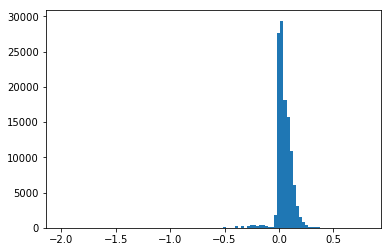

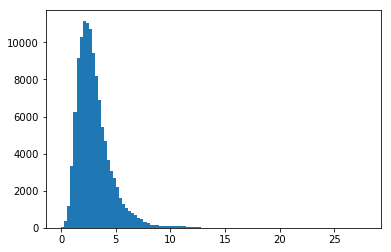

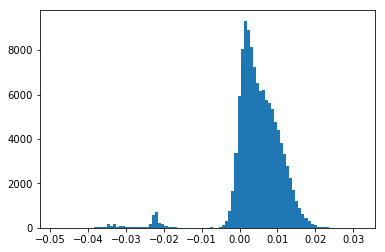

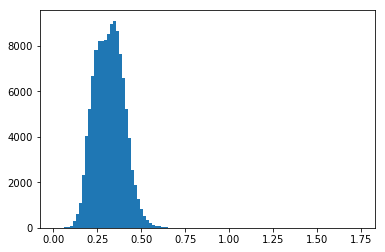

In [375]:
plt.hist(dftrain.pqf_queNorm,bins=100); plt.show()
plt.hist(dftrain.wmd_queNorm,bins=100); plt.show()
plt.hist(dftrain.pqf_queNorm2,bins=100); plt.show()
plt.hist(dftrain.wmd_queNorm2,bins=100); plt.show()

In [376]:
dftrain.tail()

,paragraph_id,question_id,paragraph,question,target,paragraphL,questionL,paragraphLS,questionLS,paragraphLX,...,idf_queNorm,idf_queNorm0,len_queIntNorm,len_queIntNorm0,idf_queIntNorm,idf_queIntNorm0,wmd_queNorm,pqf_queNorm,wmd_queNorm2,pqf_queNorm2
119393,787,78704,"С VIII века, как для Везера, так и для Верра, ...",Какие новые спортивные сооружения были построе...,0.0,"с viii век , как для везер , так и для верра ,...",какой новое спортивный сооружение быть построи...,"viii век , везер , верра , передаваться поколе...",новое спортивный сооружение построить универси...,"viii век , везер , верра , передаваться поколе...",...,0.061167,0.033937,0.000000,0.022388,0.000000,0.013541,3.583656,-0.003817,0.250856,-0.000267
119394,7414,97752,В 1049 году Балдуину V удалось отнять у Герман...,В каком году умер Райан Уайт?,0.0,в 1049 год балдуин v удаться отнять у германия...,в какой год умереть райан уайт ?,1049 год балдуин v удаться отнять германия час...,год умереть райан уайт ?,1049 год балдуин v удаться отнять германия час...,...,0.062165,0.000000,0.033333,0.033708,0.016073,NaN,5.095301,0.105876,0.318456,0.006617
119395,3845,2104,Клиническая фармакология изучает воздействие л...,Когда на всемирном конгрессе немецких школ за ...,0.0,клинический фармакология изучать воздействие л...,когда на всемирный конгресс немецкий школа за ...,клинический фармакология изучать воздействие л...,всемирный конгресс немецкий школа рубеж предст...,клинический фармакология изучать воздействие л...,...,0.157244,0.233382,0.000000,0.040541,0.000000,0.149962,3.016908,0.002534,0.460206,0.000387
119396,168,92509,Сложность выделения чистых белков затрудняла и...,Что в конце 1940-х — начале 1950-х годов разра...,0.0,сложность выделение чистый белок затруднять он...,что в конец 1940-ха — начало 1950-ха год разра...,сложность выделение чистый белок затруднять из...,конец 1940-ха — начало 1950-ха год разработать...,сложность выделение чистый белок затруднять он...,...,0.114984,0.246512,0.045455,0.079365,0.014600,0.173905,3.212299,0.010145,0.385476,0.001217
119397,2679,41770,"У типичной свободной программы (то есть, неком...",с каким персонажем происходит схватка Шерлока ...,0.0,"у типичный свободный программа ( то есть , нек...",с какой персонаж происходить схватка шерлок хо...,"типичный свободный программа ( , некоммерчески...",персонаж происходить схватка шерлок холмс филь...,"типичный свободный программа ( , некоммерчески...",...,0.200753,0.166646,0.000000,0.034884,0.000000,0.066639,2.582799,-0.019305,0.346943,-0.002593


In [377]:
dftrain.columns

Index([u'paragraph_id', u'question_id', u'paragraph', u'question', u'target',
       u'paragraphL', u'questionL', u'paragraphLS', u'questionLS',
       u'paragraphLX', u'questionLX', u'paragraphLSX', u'questionLSX',
       u'len_paragraph', u'len_question', u'len_intersection', u'idf_question',
       u'idf_paragraph', u'idf_intersection', u'len_intNorm', u'idf_intNorm',
       u'w2v_pqf', u'w2v_wmd', u'len_paragraph0', u'len_question0',
       u'len_intersection0', u'idf_question0', u'idf_paragraph0',
       u'idf_intersection0', u'len_intNorm0', u'idf_intNorm0', u'len_queNorm',
       u'len_queNorm0', u'idf_queNorm', u'idf_queNorm0', u'len_queIntNorm',
       u'len_queIntNorm0', u'idf_queIntNorm', u'idf_queIntNorm0',
       u'wmd_queNorm', u'pqf_queNorm', u'wmd_queNorm2', u'pqf_queNorm2'],
      dtype='object')

In [378]:
import xgboost as xgb
columns  = []
columns += ['len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection'] + \
           ['len_intNorm', 'idf_intNorm']
#columns += ['w2v_pq1', 'w2v_pqf', 'w2v_wmd'] + \
columns += ['w2v_wmd', 'w2v_pqf'] + \
           ['wmd_queNorm', 'pqf_queNorm'] + \
           ['wmd_queNorm2', 'pqf_queNorm2'] + \
           ['len_queNorm', 'len_queIntNorm', 'idf_queNorm', 'idf_queIntNorm']
        
columns += ['len_paragraph0', 'len_question0', 'len_intersection0', 'idf_question0', 'idf_paragraph0', 'idf_intersection0'] + \
           ['len_intNorm0', 'idf_intNorm0'] + \
           ['len_queNorm0', 'len_queIntNorm0'] #, 'idf_queNorm0', 'idf_queIntNorm0']
#model = GradientBoostingClassifier()
#model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=900, silent=True).fit(dftrain[columns], dftrain['target'])
#model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=600, silent=True).fit(dftrain[columns], dftrain['target'])
#model = GradientBoostingClassifier().fit(dftrain[columns], dftrain['target'])
#dftest['prediction']  = model.predict_proba(dftest[columns])[:, 1]
#ddftrain = model.predict_proba(dftrain[columns])[:, 1]

In [379]:
'''
def xgbtrain (param, train_x, train_y, num_round=1800, stopping=10, ratio=0.9) :
    
    split = int(round(ratio*len(train_y)))
    dtrain = xgb.DMatrix(train_x[:split],label=train_y[:split])
    dvalid = xgb.DMatrix(train_x[split:],label=train_y[split:])
    watchlist  = [(dtrain,'train'),(dvalid,'valid')]
    rvalid={}
    bst = xgb.train(param, dtrain, num_round, watchlist, feval=rmsle,early_stopping_rounds=20,evals_result=rvalid)
    return(bst,np.array(rvalid['valid']['rmsle']))

def xgbCVtrain (param, train_x, train_y, num_round=1800, stopping=10, ratio=0.9) :
    
    split = int(round(ratio*len(train_y)))
    dtrain = xgb.DMatrix(train_x[:split],label=train_y[:split])
    dvalid = xgb.DMatrix(train_x[split:],label=train_y[split:])
    watchlist  = [(dtrain,'train'),(dvalid,'valid')]
    history = xgb.cv(param, dtrain, verbose_eval=10, 
                     metrics=['rmse'],feval=rmsle,
                     num_boost_round=num_round,nfold=5,early_stopping_rounds=stopping) 
    rvalid={}
    bst    = xgb.train(param, dtrain, history['test-rmsle-mean'].argmin()+2, watchlist, evals_result=rvalid, feval=rmsle)
    #bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=rvalid, early_stopping_rounds=stopping)
    return(bst,np.array(rvalid['valid']['rmse']))
'''

param = {'silent':0, 
         'objective':'reg:logistic', 
         'eta':0.1, 
         #'max_depth':9, 
         #'subsample':0.85, 'colsample_bytree':0.8, 
         #'min_child_weight':12.0,
         #'tree_method':'exact',
         'eval_metric':'auc'}

dtrain = xgb.DMatrix(dftrain[columns], label=dftrain['target'])

if 1 :
    history = xgb.cv(param, dtrain, verbose_eval=25, metrics=['auc'],
                     num_boost_round=500,nfold=5,
                     early_stopping_rounds=20) #,stratified=True,maximize=True)

[0]	train-auc:0.996961+0.000229963	test-auc:0.996621+0.000563531
[25]	train-auc:0.998644+5.55359e-05	test-auc:0.998186+0.000189258
[50]	train-auc:0.999014+1.66925e-05	test-auc:0.998471+0.000189281
[75]	train-auc:0.999171+2.33015e-05	test-auc:0.998571+0.000146877
[100]	train-auc:0.999311+2.01455e-05	test-auc:0.998615+0.000133763
[125]	train-auc:0.99945+2.66983e-05	test-auc:0.998638+0.000131272
[150]	train-auc:0.999561+3.24838e-05	test-auc:0.998661+0.000132037
[175]	train-auc:0.999654+2.91753e-05	test-auc:0.99868+0.000133323
[200]	train-auc:0.999731+3.01105e-05	test-auc:0.998689+0.000128554
[225]	train-auc:0.999791+2.21215e-05	test-auc:0.998697+0.000131431
[250]	train-auc:0.99984+1.77358e-05	test-auc:0.998702+0.000130693
[275]	train-auc:0.999877+1.78729e-05	test-auc:0.998703+0.000126237
[300]	train-auc:0.999909+1.59825e-05	test-auc:0.998705+0.00013059
[325]	train-auc:0.999935+1.38651e-05	test-auc:0.99871+0.000128412
[350]	train-auc:0.999953+1.0028e-05	test-auc:0.998713+0.000129975
[375]	

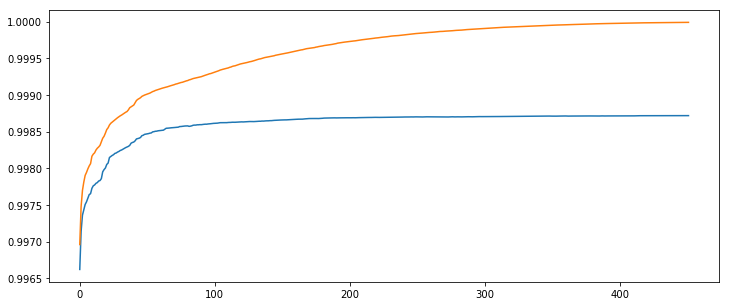

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
432,0.998719,0.000125,0.999988,0.000003
433,0.998718,0.000125,0.999989,0.000004
434,0.998718,0.000124,0.999989,0.000004
435,0.998718,0.000124,0.999989,0.000004
436,0.998718,0.000124,0.999989,0.000003
437,0.998718,0.000124,0.999989,0.000003
438,0.998718,0.000123,0.999989,0.000003
439,0.998718,0.000124,0.999989,0.000003
440,0.998718,0.000124,0.999990,0.000003
441,0.998719,0.000124,0.999990,0.000003


In [380]:
plt.figure(figsize=(12,5))
plt.plot(history['test-auc-mean']); 
plt.plot(history['train-auc-mean']); 
plt.show();
history.tail(20)

In [393]:
num_round = 400
watchlist  = [(dtrain,'train')]

bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=20,verbose_eval=50)

[0]	train-auc:0.997244
Will train until train-auc hasn't improved in 20 rounds.
[50]	train-auc:0.998961
[100]	train-auc:0.999255
[150]	train-auc:0.9995
[200]	train-auc:0.999685
[250]	train-auc:0.999785
[300]	train-auc:0.999861
[350]	train-auc:0.999915


In [394]:
dtest    = xgb.DMatrix(dftest[columns])
ddftest  = bst.predict(dtest)
ddftrain = bst.predict(dtrain)
dftest['prediction']=ddftest
ddftest.shape, ddftest[:20]

((491449,), array([  1.39191332e-06,   2.82517226e-06,   3.02265630e-06,
          1.30987202e-04,   3.29296404e-06,   3.49082279e-06,
          4.15763452e-06,   2.05872425e-06,   5.44116210e-06,
          2.19185749e-05,   3.57494127e-06,   3.67965572e-06,
          2.47289836e-06,   1.02160448e-06,   6.60874284e-05,
          3.43208521e-05,   8.26740146e-01,   2.07085614e-05,
          3.08992567e-05,   2.36221931e-05], dtype=float32))

In [369]:
bst.get_fscore()

{'idf_intNorm': 491,
 'idf_intNorm0': 189,
 'idf_intersection': 226,
 'idf_intersection0': 174,
 'idf_paragraph': 256,
 'idf_paragraph0': 348,
 'idf_queIntNorm': 193,
 'idf_queNorm': 187,
 'idf_question': 243,
 'idf_question0': 230,
 'len_intNorm': 113,
 'len_intNorm0': 267,
 'len_intersection': 12,
 'len_intersection0': 230,
 'len_paragraph': 168,
 'len_paragraph0': 189,
 'len_queIntNorm': 214,
 'len_queIntNorm0': 241,
 'len_queNorm': 100,
 'len_queNorm0': 149,
 'len_question': 19,
 'len_question0': 91,
 'pqf_queNorm': 325,
 'pqf_queNorm2': 235,
 'w2v_pqf': 407,
 'w2v_wmd': 598,
 'wmd_queNorm': 137,
 'wmd_queNorm2': 193}

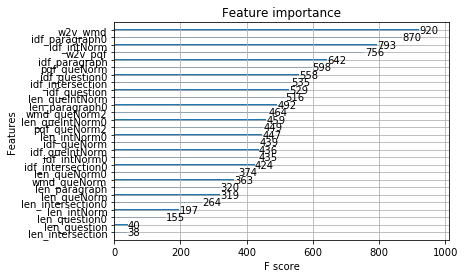

In [395]:
plt.figure(figsize=(15,8))
xgb.plot_importance(bst); plt.show()

In [396]:
ddftest = dftest.groupby(by=['paragraph_id', 'question_id'])['prediction'].max().reset_index()

In [397]:
ddftest.tail()
#xx = dftest['paragraph_id'].unique()
#xx.sort(); xx

,paragraph_id,question_id,prediction
74285,1627,33917,0.980625
74286,1627,34164,0.999830
74287,1627,34899,0.991352
74288,1627,36819,0.122811
74289,1627,38856,0.999999


In [398]:
dftest[['paragraph_id', 'question_id', 'prediction']].head()

,paragraph_id,question_id,prediction
0,1361,6463,0.000001
0,1361,6463,0.000003
0,1361,6463,0.000003
0,1361,6463,0.000131
0,1361,6463,0.000003


In [402]:
# LB=0.9300849192457006
ddftest[['paragraph_id', 'question_id', 'prediction']].to_csv("../Result/prediction-2017-10-30-18-30.csv", index=False)

accuracy=0.99712 roc_auc=0.99663


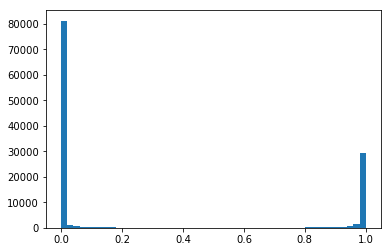

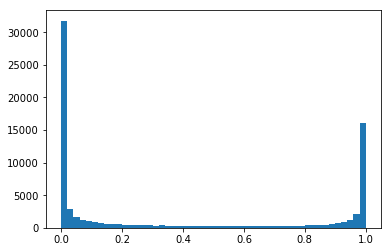

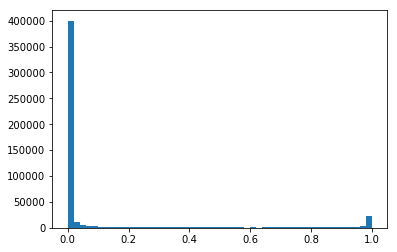

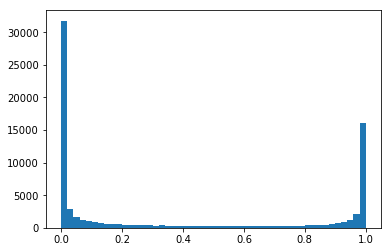

In [401]:
print 'accuracy={:.5f} roc_auc={:.5f}'.format(skm.accuracy_score(dftrain['target'].values,ddftrain>0.5),
           skm.roc_auc_score(dftrain['target'].values,ddftrain>0.5))
plt.hist(ddftrain,bins=50); plt.show()
plt.hist(ddftest['prediction'],bins=50); plt.show()
plt.hist(dftest['prediction'],bins=50); plt.show()
plt.hist(ddftest['prediction'],bins=50); plt.show()

accuracy=0.98976 roc_auc=0.98807


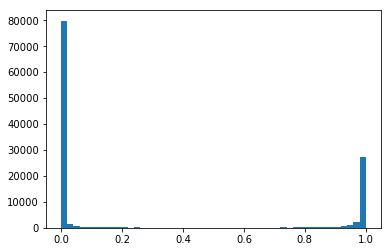

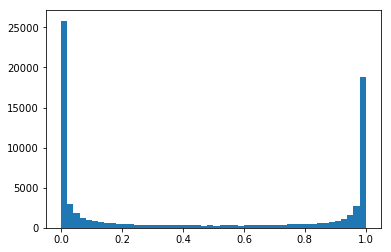

In [93]:
print 'accuracy={:.5f} roc_auc={:.5f}'.format(skm.accuracy_score(dftrain['target'].values,ddftrain>0.5),
           skm.roc_auc_score(dftrain['target'].values,ddftrain>0.5))
plt.hist(ddftrain,bins=50); plt.show()
plt.hist(dftest['prediction'],bins=50); plt.show()

0.973935911824


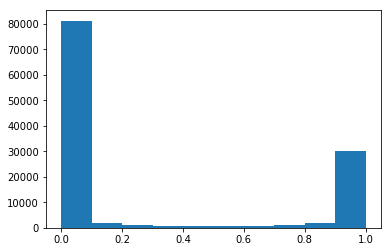

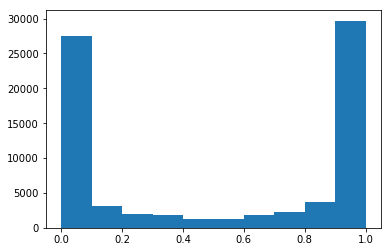

In [145]:
print skm.accuracy_score(dftrain['target'].values,ddftrain>0.5)
plt.hist(ddftrain); plt.show()
plt.hist(dftest['prediction']); plt.show()

In [21]:
import gensim.models.word2vec

Using TensorFlow backend.


In [40]:
sentences  = dftrain['paragraphL'].tolist()+dftrain.questionL.tolist()
sentences += dftest ['paragraphL'].tolist()+dftest.questionL.tolist()
#sentences += dftest ['paragraph'].tolist()+dftest ['question'].tolist()
sentences = [[ss.decode('utf-8') for ss in s.split(' ')] for s in sentences]
print len(sentences) #, sentences[0]
len(sentences)

2109476


2109476

In [41]:
print datetime.datetime.now()
model = gensim.models.word2vec.Word2Vec(sentences, size=100, window=5, workers=4, min_count=1)
print datetime.datetime.now()

2017-10-28 19:58:44.384072
2017-10-28 20:04:31.241479


In [43]:
print sentences[0][5]

земноводный


In [44]:
model.wv[sentences[1][1]]

array([ -2.98387313e+00,   5.51913261e+00,   7.42003059e+00,
         4.52600813e+00,   1.42700901e+01,  -3.03050518e+00,
         2.59337997e+00,  -3.26727843e+00,  -1.52219963e+00,
         5.91764545e+00,  -4.89653063e+00,   8.80865455e-01,
        -6.35947466e-01,  -4.66090727e+00,   3.15288448e+00,
        -3.46123910e+00,   1.19812751e+00,  -2.79872561e+00,
        -2.66737413e+00,  -2.54326153e+00,   4.76887846e+00,
        -4.23117161e+00,   8.84592831e-01,   1.07003033e+00,
        -1.06999767e+00,   1.02019989e+00,   7.04411983e+00,
         1.40653050e+00,  -2.67896438e+00,   1.14307380e+00,
        -4.62081575e+00,  -9.75797117e-01,   2.75414991e+00,
        -5.19478858e-01,  -9.16263294e+00,  -7.18607485e-01,
         6.99500465e+00,   2.22612309e+00,  -5.58874083e+00,
         6.27894831e+00,   6.10575342e+00,  -1.15751280e-02,
        -8.38653946e+00,  -4.22843277e-01,   5.44648457e+00,
        -5.09045267e+00,   4.85996532e+00,   3.59171939e+00,
        -1.23300278e+00,

In [47]:
model.get_latest_training_loss()
#model.accuracy()

0.0

In [48]:
wv = model.wv
print wv.__dict__.keys()
print 'vector_size',wv.__dict__['vector_size']
print 'syn0',wv.__dict__['syn0'].shape #,wv.__dict__['syn0']
print wv.__dict__['syn0norm']
print 'vocab',len(wv.__dict__['vocab']),wv.__dict__['vocab'].keys()[:5]
for word in wv.__dict__['vocab'].keys()[:50] :
    print word
#print 'index2word',wv.__dict__['index2word'],wv.__dict__['index2word'][0]


['syn0norm', 'vocab', 'index2word', 'vector_size', 'syn0']
vector_size None
syn0 (79809, 100)
None
vocab 79809 [u'', u'hcho', u'diy-\u0438\u0434\u0435\u043e\u043b\u043e\u0433\u0438\u044f', u'\u043a\u043e\u043b\u0442\u0443\u043d', u'\u0441\u043e\u0431\u0440\u0430\u0442']

hcho
diy-идеология
колтун
собрат
соr
гольфстрим
грызун
деноминация
гласный-согласный
нормальный
субсоциальность
woods
анкара
spiders
francesco
francesca
сахаромицет
нуклид
излиться
бенефициарный
имхотёпа
ребровый
слоговой
районирование
gentis
лашко
взмах
гомозиготный
отстоять
евграф
ядовитость
псевдополовый
пектиназа
данаиды-монарх
богословие
hermann
ногайский
балаганчик
пронский
наготове
восприимчивый
четырёхстраничный
40,8
λεπίδος
со2
хабаровский
40,4
40,5
властелин


In [82]:
#for index, row0 in df.iterrows() 
print datetime.datetime.now()
#dftrain = dftrain.reset_index()
#dftest  = dftest.reset_index()
#print dftest.head()
ilong, ibad, ilist = 0, 0, []
for name, df in [('train',dftrain),('test',dftest)] :
    for ii,row in df.iterrows() :
        if ii%50000==0 : print datetime.datetime.now(), name, ii
        if name=='train' and row.target==1 : ilong += 1
        pp = row.paragraphLSX.split()
        qq = row.questionLSX.split()
        tt = row.target if name=='train' else 0.0
        try :
            ns = wv.n_similarity([unicode(ppx,'utf-8') for ppx in pp],[unicode(qqx,'utf-8') for qqx in qq])
            ilist.append([tt,ns])
            #print '\t',ii,row.target,ns
        except : ibad += 1; #print '\t',ii,row.target,'--------------- bad bad'
    if name=='train' : trainlist = np.array(ilist)
    if name=='test'  : testlist  = np.array(ilist)
print datetime.datetime.now()

2017-10-28 20:31:51.943359
2017-10-28 20:31:52.259137 train 0
2017-10-28 20:31:54.273526 train 10000
2017-10-28 20:31:56.342125 train 20000
2017-10-28 20:31:58.330599 train 30000
2017-10-28 20:32:00.310624 train 40000
2017-10-28 20:32:02.301252 train 50000
2017-10-28 20:32:04.300879 train 60000
2017-10-28 20:32:06.305857 train 70000
2017-10-28 20:32:08.428460 train 80000
2017-10-28 20:32:10.505278 train 90000
2017-10-28 20:32:12.509864 train 100000
2017-10-28 20:32:14.676475 train 110000
2017-10-28 20:32:16.694803 train 120000
2017-10-28 20:32:18.741870 train 130000
2017-10-28 20:32:20.749405 train 140000
2017-10-28 20:32:22.744605 train 150000
2017-10-28 20:32:24.716175 train 160000
2017-10-28 20:32:26.698143 train 170000
2017-10-28 20:32:28.800694 train 180000
2017-10-28 20:32:30.768833 train 190000
2017-10-28 20:32:32.714025 train 200000
2017-10-28 20:32:34.687650 train 210000
2017-10-28 20:32:36.632489 train 220000
2017-10-28 20:32:38.590477 train 230000
2017-10-28 20:32:40.556579 

In [89]:
ilong/dftrain.shape[0], dftrain.target.mean()

(0.06791362870569104, 0.067913628705691037)

537565 1009514 (537565, 2) 45224 38255


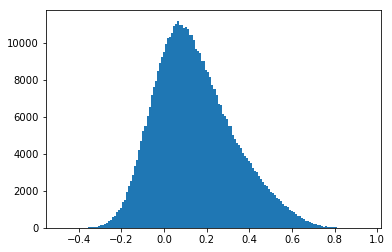

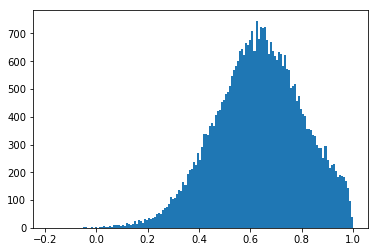

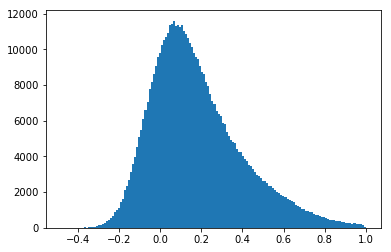

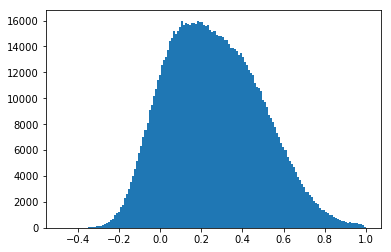

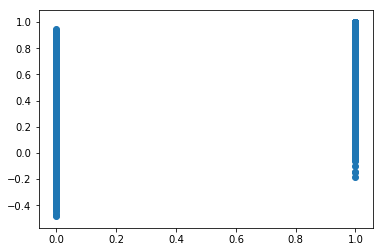

In [92]:
print len(trainlist), len(testlist), trainlist.shape, ibad, ilong
plt.hist(trainlist[trainlist[:,0]==0,1],bins=150); plt.show();
plt.hist(trainlist[trainlist[:,0]==1,1],bins=150); plt.show();
plt.hist(np.array(trainlist[:,1]),bins=150); plt.show();
plt.hist(np.array(testlist[:,1]), bins=150); plt.show();

plt.scatter(trainlist[:,0],trainlist[:,1]); plt.show();


In [65]:
dff = dftrain.copy()
dff.head()
del dff

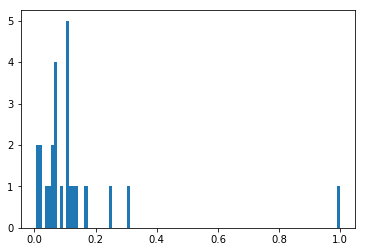

In [276]:
lsx = []
for pw in unicode(dftrain.paragraphLSX[0]).split()[:5] :
    for qw in unicode(dftrain.questionLSX[0]).split()[:5] :
        try : 
            #print pw,qw,wv.similarity(pw,qw); 
            lsx.append(abs(wv.similarity(pw,qw)))
        except : continue
plt.hist(np.array(lsx),bins=100); plt.show()

In [269]:
unicode(dftrain.paragraphLSX[0]).split()

[u'0',
 u'\u043e\u0442\u043b\u0438\u0447\u0438\u0435',
 u'\u0440\u044b\u0431\u0430',
 u',',
 u'\u0437\u0435\u043c\u043d\u043e\u0432\u043e\u0434\u043d\u044b\u0439',
 u'(',
 u'\u0430\u043c\u0444\u0438\u0431\u0438\u044f',
 u')',
 u'\u043f\u0440\u0435\u0441\u043c\u044b\u043a...',
 u'0',
 u'\u0435\u0434\u0438\u043d\u0441\u0442\u0432\u0435\u043d\u043d\u044b\u0439',
 u'\u0441\u043e\u0432\u0440\u0435\u043c\u0435\u043d\u043d\u044b\u0439',
 u'\u0440\u0435\u043f\u0442\u0438\u043b\u0438\u044f',
 u',',
 u'\u0438\u043c\u0435\u0442\u044c',
 u'\u043d\u0435\u043f...',
 u'0',
 u'\u0441\u0447\u0438\u0442\u0430\u0442\u044c\u0441\u044f',
 u',',
 u'\u0432\u043f\u0435\u0440\u0432\u044b\u0435',
 u'\u0447\u0435\u0442\u044b\u0440\u0451\u0445\u043a\u0430\u043c\u0435\u0440\u043d\u044b\u0439',
 u'\u0441\u0435\u0440\u0434\u0446\u0435',
 u'\u043f\u043e...',
 u'0',
 u'\u0434\u0430\u043b\u044c\u043d\u0435\u0439\u0448\u0438\u0439',
 u'\u0441\u0442\u0440\u043e\u0435\u043d\u0438\u0435',
 u'\u0441\u0435\u0440\u0434\u0446\

In [28]:
aa=Counter('aabb bcccc'); aa
#aa=Counter({'aa':6, 'b':7}); aa

Counter({' ': 1, 'a': 2, 'b': 3, 'c': 4})

In [85]:
import pymorphy2
morphy = pymorphy2.MorphAnalyzer()
morphy.parse(u'вова')
print morphy.parse(u'вову')[0].normal_form
#str(morphy.parse(u'вовочка')[0].normal_form) #.encode('cp1251')

вова


In [112]:
wword = u'четвертый пересидевший'
print len(morphy.parse(wword)),morphy.parse(wword)
print morphy.parse(wword)[0].normal_form
for pp in morphy.parse(wword) : print pp.normal_form, pp.score, pp.tag

4 [Parse(word=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', tag=OpencorporaTag('PRTF,perf,intr,past,actv masc,sing,nomn'), normal_form=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0442\u044c', score=0.4831932773109244, methods_stack=((<FakeDictionary>, u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', 715, 15), (<KnownSuffixAnalyzer>, u'\u0435\u0432\u0448\u0438\u0439'))), Parse(word=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0432\u0448\u0438\u0439', tag=OpencorporaTag('PRTF,perf,intr,past,actv inan,masc,sing,accs'), normal_form=u'\u0447\u0435\u0442\u0432\u0435\u0440\u0442\u044b\u0439 \u043f\u0435\u0440\u0435\u0441\u0438\u0434\u0435\u0442\u044c', score=0.4831932773109244, methods_stack=((<FakeDicti

In [75]:
print unicode(u'вщвщчка')
#str(u'вщвщчка'.decode('utf_8'))

вщвщчка


In [74]:
print 'вовочка'.decode('utf-8')

вовочка


In [200]:
import nltk

In [217]:
dftrain.columns

Index([u'paragraph_id', u'question_id', u'paragraph', u'question', u'target',
       u'len_paragraph', u'len_question', u'len_intersection', u'idf_question',
       u'idf_paragraph', u'idf_intersection', u'len_paragraph0',
       u'len_question0', u'len_intersection0', u'idf_question0',
       u'idf_paragraph0', u'idf_intersection0'],
      dtype='object')

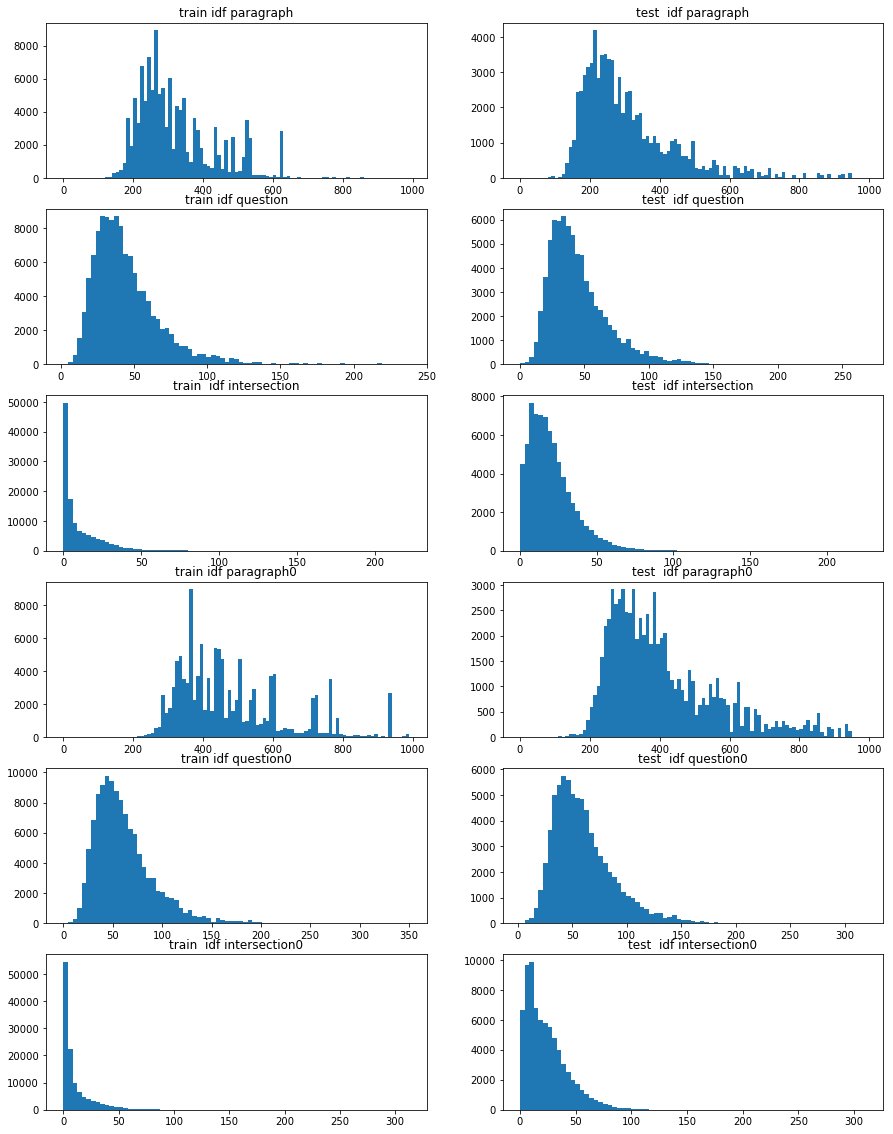

In [253]:
plt.figure(figsize=(15,20))
bbins = [xx for xx in range(0,1000,10)]
plt.subplot(621); plt.hist(dftrain.idf_paragraph,bins=bbins); plt.title('train idf paragraph')
plt.subplot(622);plt.hist(dftest.idf_paragraph,bins=bbins);   plt.title('test  idf paragraph') 
plt.subplot(623); plt.hist(dftrain.idf_question,bins=75);     plt.title('train idf question')
plt.subplot(624);plt.hist(dftest.idf_question,bins=75);       plt.title('test  idf question')
plt.subplot(625);plt.hist(dftrain.idf_intersection,bins=75);       plt.title('train  idf intersection')
plt.subplot(626);plt.hist(dftest.idf_intersection,bins=75);       plt.title('test  idf intersection')

plt.subplot(627); plt.hist(dftrain.idf_paragraph0,bins=bbins);plt.title('train idf paragraph0')
plt.subplot(628);plt.hist(dftest.idf_paragraph0,bins=bbins);  plt.title('test  idf paragraph0')
plt.subplot(629); plt.hist(dftrain.idf_question0,bins=75);    plt.title('train idf question0')
plt.subplot(6,2,10);plt.hist(dftest.idf_question0,bins=75);      plt.title('test  idf question0')
plt.subplot(6,2,11);plt.hist(dftrain.idf_intersection0,bins=75);      plt.title('train  idf intersection0')
plt.subplot(6,2,12);plt.hist(dftest.idf_intersection0,bins=75);      plt.title('test  idf intersection0')

plt.show()

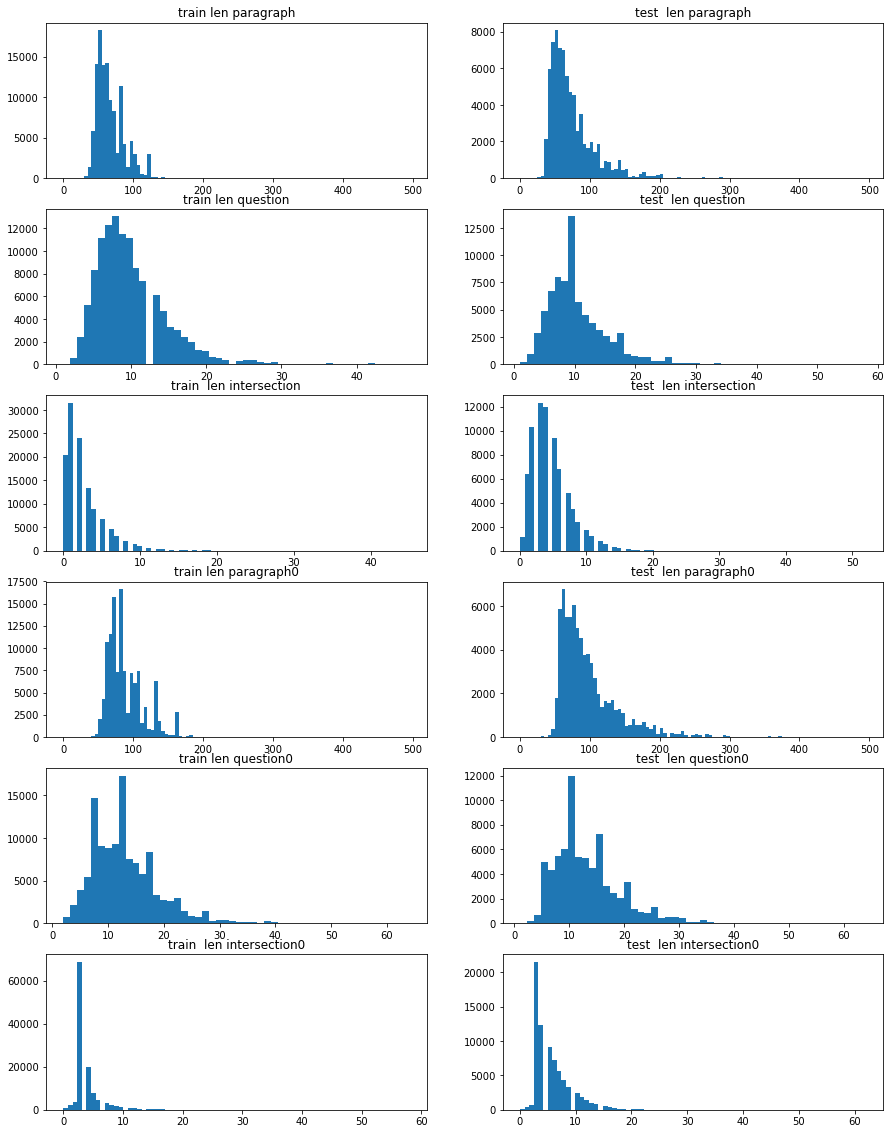

In [252]:
plt.figure(figsize=(15,20))
bbins = [xx for xx in range(0,500,5)]
plt.subplot(621); plt.hist(dftrain.len_paragraph,bins=bbins); plt.title('train len paragraph')
plt.subplot(622);plt.hist(dftest.len_paragraph,bins=bbins);   plt.title('test  len paragraph') 
plt.subplot(623); plt.hist(dftrain.len_question,bins=50);     plt.title('train len question')
plt.subplot(624);plt.hist(dftest.len_question,bins=50);       plt.title('test  len question')
plt.subplot(625);plt.hist(dftrain.len_intersection,bins=75);       plt.title('train  len intersection')
plt.subplot(626);plt.hist(dftest.len_intersection,bins=75);       plt.title('test  len intersection')

plt.subplot(627); plt.hist(dftrain.len_paragraph0,bins=bbins);plt.title('train len paragraph0')
plt.subplot(628);plt.hist(dftest.len_paragraph0,bins=bbins);  plt.title('test  len paragraph0')
plt.subplot(629); plt.hist(dftrain.len_question0,bins=50);    plt.title('train len question0')
plt.subplot(6,2,10);plt.hist(dftest.len_question0,bins=50);      plt.title('test  len question0')
plt.subplot(6,2,11);plt.hist(dftrain.len_intersection0,bins=75);      plt.title('train  len intersection0')
plt.subplot(6,2,12);plt.hist(dftest.len_intersection0,bins=75);      plt.title('test  len intersection0')

plt.show()

In [274]:
skf = skms.StratifiedKFold(n_splits=3)
X = [11,22,33,44,55,66,77,88,99,10]; 
y = [11,11,11,11,11,22,22,22,22,22]; 
print(X)
for train_index, test_index in skf.split(X,y) :
    print 'train={} test={}'.format(train_index,test_index)
    print np.array(X)[train_index]
    print np.array(X)[test_index]


[11, 22, 33, 44, 55, 66, 77, 88, 99, 10]
train=[2 3 4 7 8 9] test=[0 1 5 6]
[33 44 55 88 99 10]
[11 22 66 77]
train=[0 1 4 5 6 9] test=[2 3 7 8]
[11 22 55 66 77 10]
[33 44 88 99]
train=[0 1 2 3 5 6 7 8] test=[4 9]
[11 22 33 44 66 77 88 99]
[55 10]


In [336]:
skf = skms.StratifiedKFold(n_splits=10)
import xgboost as xgb
columns  = []
columns += ['len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection']
columns += ['len_paragraph0', 'len_question0', 'len_intersection0', 'idf_question0', 'idf_paragraph0', 'idf_intersection0']
#model = GradientBoostingClassifier()
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=300, silent=True)
scores = skms.cross_val_score(model, dftrain[columns], dftrain['target'], cv=skf, scoring='roc_auc');
#dftest['prediction']  = model.predict_proba(dftest[columns])[:, 1]
#ddftrain = model.predict_proba(dftrain[columns])[:, 1]
np.array(scores).mean(), np.array(scores).std(), scores

(0.99839152723779545,
 0.00012748411913640487,
 array([ 0.99834759,  0.99852797,  0.99835356,  0.99835328,  0.99859732,
         0.99834908,  0.99856697,  0.99815247,  0.99832212,  0.99834491]))

In [335]:
np.array(scores).mean(), np.array(scores).std(), scores

(0.99835128988464183,
 0.00013363048368364195,
 array([ 0.99830495,  0.99850091,  0.99830191,  0.99829347,  0.99856759,
         0.99828593,  0.99852408,  0.99809739,  0.99833713,  0.99829954]))